In [1]:

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = "results"
FIG_DIR = "figures"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

plt.rcParams.update({
    "figure.figsize": (6, 4),
    "axes.grid": True,
    "grid.alpha": 0.35,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 2.0,
})
%matplotlib inline


In [2]:

def read_csv_safe(path):
    try:
        df = pd.read_csv(path)
        df.columns = [c.strip() for c in df.columns]
        df.columns = [c.lower().replace(' ', '_') for c in df.columns]
        return df
    except Exception as e:
        print(f"Failed to read {path}: {e}")
        return pd.DataFrame()

def to_dt(series, fmt=None):
    try:
        return pd.to_datetime(series, errors='coerce', format=fmt)
    except Exception:
        return pd.to_datetime(series, errors='coerce')

def month_key(ts_col):
    ts = to_dt(ts_col)
    return ts.dt.to_period('M').dt.to_timestamp()

def find_all(pattern):
    return sorted(glob.glob(os.path.join(RESULTS_DIR, pattern)))


In [3]:

fixed_p75_paths   = find_all("fixed_prices_*_p75.csv")
fixed_pgrid_paths = find_all("fixed_prices_*_pgrid.csv")
breakdown_paths   = find_all("price_breakdown_*.csv")
gen_paths         = find_all("expected_generation_*.csv")

fixed_p75   = pd.concat([read_csv_safe(p) for p in fixed_p75_paths], ignore_index=True) if fixed_p75_paths else pd.DataFrame()
fixed_pgrid = pd.concat([read_csv_safe(p) for p in fixed_pgrid_paths], ignore_index=True) if fixed_pgrid_paths else pd.DataFrame()
bkdwn_all   = pd.concat([read_csv_safe(p) for p in breakdown_paths],   ignore_index=True) if breakdown_paths   else pd.DataFrame()
gen_all     = pd.concat([read_csv_safe(p) for p in gen_paths],         ignore_index=True) if gen_paths         else pd.DataFrame()

# normalize
if not fixed_p75.empty:
    fixed_p75 = fixed_p75.rename(columns={"fixedprice":"fixed_price","p":"p_level","product_type":"product"})
if not fixed_pgrid.empty:
    fixed_pgrid = fixed_pgrid.rename(columns={"fixedprice":"fixed_price","p":"p_level","product_type":"product"})
if not gen_all.empty:
    if "ts" in gen_all.columns:
        gen_all["ts"] = to_dt(gen_all["ts"])
        gen_all["month_key"] = month_key(gen_all["ts"])
    elif "month" in gen_all.columns:
        gen_all["month_key"] = to_dt(gen_all["month"]).dt.to_period('M').dt.to_timestamp()
    if "gen_mwh" not in gen_all.columns:
        for cand in ["gen","generation_mwh","mwh","gen_mean"]:
            if cand in gen_all.columns:
                gen_all = gen_all.rename(columns={cand:"gen_mwh"})
                break
if not bkdwn_all.empty:
    for c in ["hub_mean","basis_mean","spr_hub_mean","spr_node_mean","risk_adj","fixed_price","asset","product"]:
        if c not in bkdwn_all.columns:
            bkdwn_all[c] = np.nan


## 1) P75 Fixed Prices — Bars per Product (per Asset)

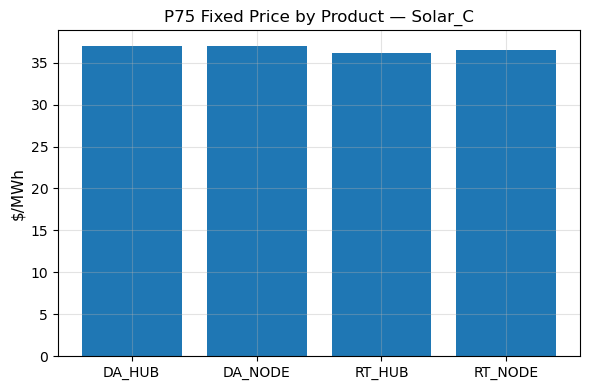

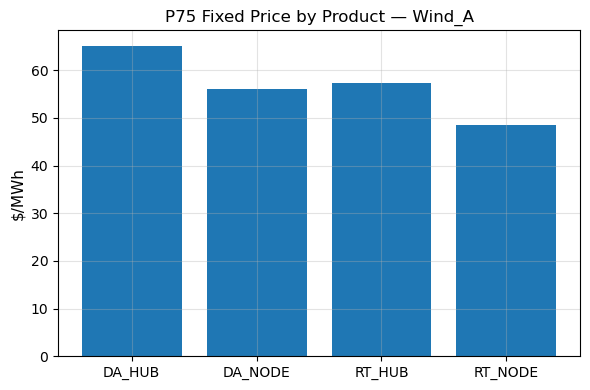

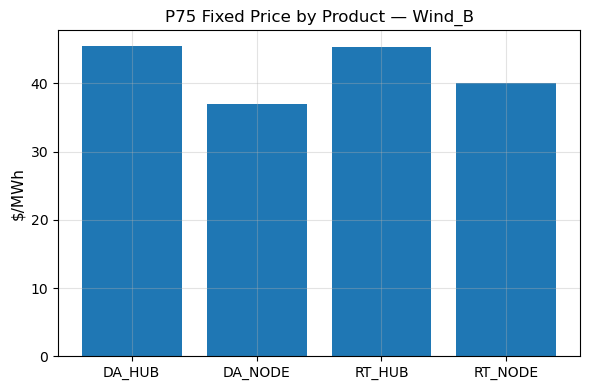

In [4]:

if not fixed_p75.empty and set(["asset","product","fixed_price"]).issubset(fixed_p75.columns):
    fixed_p75["fixed_price"] = pd.to_numeric(fixed_p75["fixed_price"], errors="coerce")
    for a, df_a in fixed_p75.groupby("asset"):
        df_a = df_a.sort_values("product")
        x = np.arange(len(df_a))
        plt.figure()
        plt.bar(x, df_a["fixed_price"])
        plt.xticks(x, df_a["product"], rotation=0)
        plt.ylabel("$/MWh")
        plt.title(f"P75 Fixed Price by Product — {a}")
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f"{a}_p75_fixed_price.png"), dpi=150)
        plt.show()


## 2) Fixed Price vs P-Level 

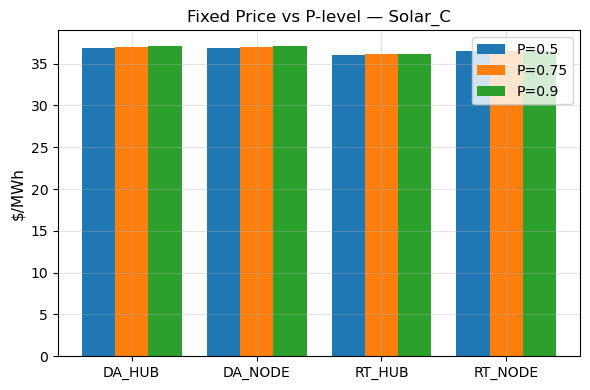

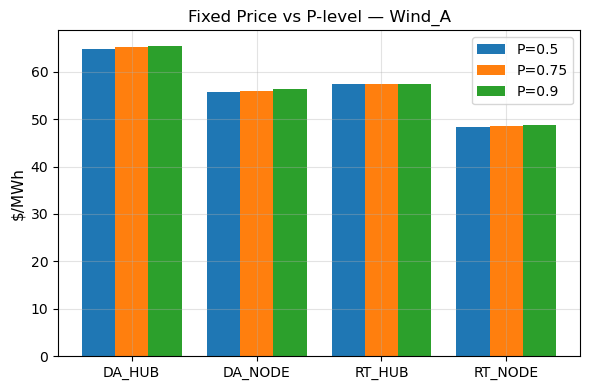

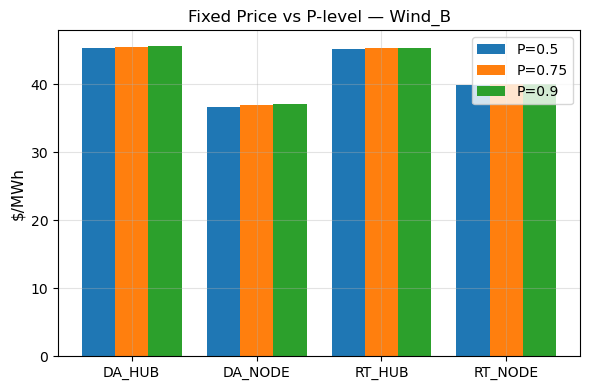

In [5]:

if not fixed_pgrid.empty and set(["asset","product","p_level","fixed_price"]).issubset(fixed_pgrid.columns):
    df = fixed_pgrid.copy()
    df["p_level"] = pd.to_numeric(df["p_level"], errors="coerce")
    df["fixed_price"] = pd.to_numeric(df["fixed_price"], errors="coerce")
    # use canonical order for p-levels across assets
    p_order = sorted(df["p_level"].dropna().unique())
    for a, df_a in df.groupby("asset"):
        df_a = df_a[df_a["p_level"].isin(p_order)].copy()
        if df_a.empty: 
            continue
        # pivot: rows=product, cols=p_level, values=fixed_price
        piv = df_a.pivot_table(index="product", columns="p_level", values="fixed_price", aggfunc="mean")
        piv = piv.reindex(columns=p_order)
        prods = list(piv.index)
        x = np.arange(len(prods))
        width = 0.8 / max(1, len(p_order))  # grouped bars
        plt.figure()
        for i, p in enumerate(p_order):
            vals = pd.to_numeric(piv[p], errors="coerce").fillna(0.0).values
            plt.bar(x + i*width - 0.4 + width/2, vals, width=width, label=f"P={p:g}")
        plt.xticks(x, prods, rotation=0)
        plt.ylabel("$/MWh")
        plt.title(f"Fixed Price vs P-level — {a}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f"{a}_pgrid_grouped_bars.png"), dpi=150)
        plt.show()


## 3) Price Components 

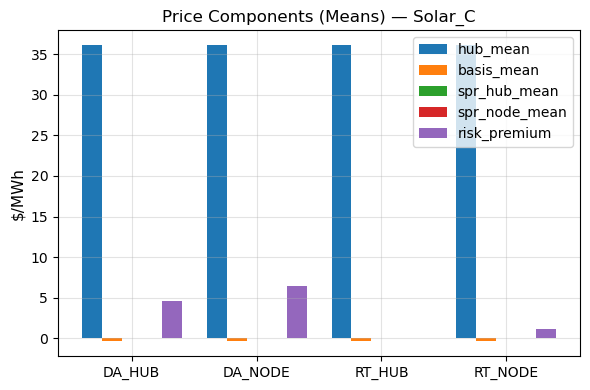

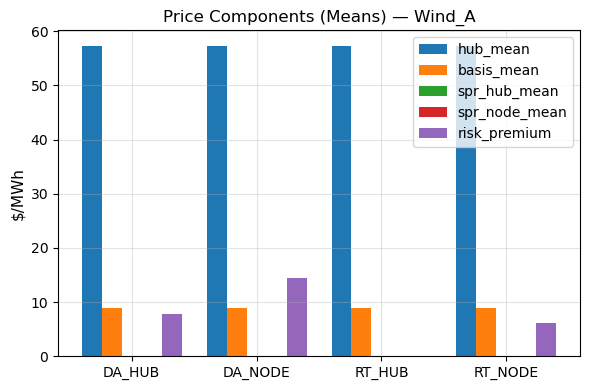

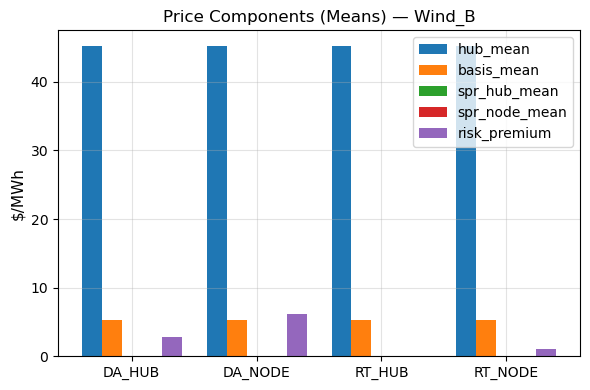

In [9]:

if not bkdwn_all.empty and set(["asset","product"]).issubset(bkdwn_all.columns):
    comp_cols = ["hub_mean","basis_mean","spr_hub_mean","spr_node_mean","risk_premium"]
    for a, df_a in bkdwn_all.groupby("asset"):
        # mean component value per product
        agg = df_a.groupby("product", as_index=False)[comp_cols].mean(numeric_only=True)
        if agg.empty:
            continue
        prods = list(agg["product"])
        x = np.arange(len(prods))
        k = len(comp_cols)
        width = 0.8 / max(1, k)
        plt.figure()
        for i, c in enumerate(comp_cols):
            vals = pd.to_numeric(agg[c], errors="coerce").fillna(0.0).values
            plt.bar(x + i*width - 0.4 + width/2, vals, width=width, label=c)
        plt.xticks(x, prods, rotation=0)
        plt.ylabel("$/MWh")
        plt.title(f"Price Components (Means) — {a}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR, f"{a}_breakdown_grouped_bars.png"), dpi=150)
        plt.show()


## 4) Expected Generation

In [7]:

if not gen_all.empty and "asset" in gen_all.columns and "gen_mwh" in gen_all.columns:
    # Hourly preview (first 3 days per asset, bars)
    if "ts" in gen_all.columns:
        for a, df_a in gen_all.groupby("asset"):
            window = df_a.dropna(subset=["ts"]).sort_values("ts").iloc[:24*3]
            if not window.empty:
                y = pd.to_numeric(window["gen_mwh"], errors="coerce").fillna(0.0).values
                x = np.arange(len(window))
                plt.figure()
                plt.bar(x, y)
                plt.xticks(x[::6], window["ts"].dt.strftime("%m-%d %H:%M").iloc[::6], rotation=45)
                plt.ylabel("MWh")
                plt.title(f"Hourly Generation (first 3 days) — {a}")
                plt.tight_layout()
                plt.savefig(os.path.join(FIG_DIR, f"{a}_gen_hourly_bars_preview.png"), dpi=150)
                plt.show()
    # Monthly totals (bars), optionally split Peak/Off-peak
    if "month_key" in gen_all.columns:
        g = gen_all.copy()
        g["gen_mwh"] = pd.to_numeric(g["gen_mwh"], errors="coerce")
        for a, df_a in g.groupby("asset"):
            plt.figure()
            if "is_peak" in df_a.columns and df_a["is_peak"].notna().any():
                # two bars per month: Peak vs Off
                mon_peak = (df_a[df_a["is_peak"]==True]
                            .groupby("month_key", as_index=False)["gen_mwh"].sum()
                            .sort_values("month_key"))
                mon_off  = (df_a[df_a["is_peak"]==False]
                            .groupby("month_key", as_index=False)["gen_mwh"].sum()
                            .sort_values("month_key"))
                months = sorted(set(mon_peak["month_key"]).union(set(mon_off["month_key"])))
                x = np.arange(len(months))
                width = 0.35
                p_vals = pd.to_numeric(mon_peak.set_index("month_key").reindex(months)["gen_mwh"], errors="coerce").fillna(0.0).values
                o_vals = pd.to_numeric(mon_off.set_index("month_key").reindex(months)["gen_mwh"], errors="coerce").fillna(0.0).values
                plt.bar(x - width/2, p_vals, width=width, label="Peak")
                plt.bar(x + width/2, o_vals, width=width, label="Off-peak")
                xt = [pd.Timestamp(m).strftime("%Y-%m") for m in months]
                plt.xticks(x[::2], xt[::2], rotation=45)
                plt.ylabel("MWh")
                plt.title(f"Monthly Generation — {a}")
                plt.legend()
            else:
                mon = df_a.groupby("month_key", as_index=False)["gen_mwh"].sum().sort_values("month_key")
                x = np.arange(len(mon))
                plt.bar(x, pd.to_numeric(mon["gen_mwh"], errors="coerce").values)
                xt = mon["month_key"].dt.strftime("%Y-%m").tolist()
                plt.xticks(x[::2], xt[::2], rotation=45)
                plt.ylabel("MWh")
                plt.title(f"Monthly Generation — {a}")
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f"{a}_gen_monthly_bars.png"), dpi=150)
            plt.show()


## 5) Overlay — Fixed Price (P75) vs Hub Mean

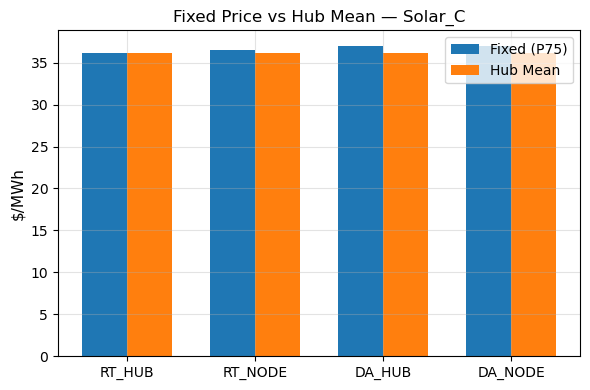

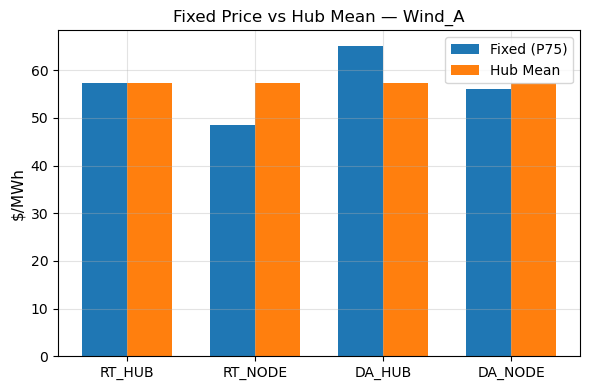

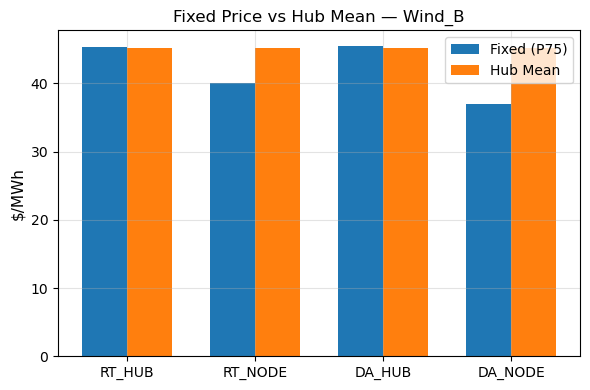

In [8]:

if (not fixed_p75.empty) and (not bkdwn_all.empty) and set(["asset","product","fixed_price"]).issubset(fixed_p75.columns):
    f = fixed_p75.copy()
    f["fixed_price"] = pd.to_numeric(f["fixed_price"], errors="coerce")
    if "hub_mean" in bkdwn_all.columns:
        hub_means = bkdwn_all.groupby(["asset","product"], as_index=False)["hub_mean"].mean(numeric_only=True)
        for a, fa in f.groupby("asset"):
            m = fa.merge(hub_means[hub_means["asset"]==a], on=["asset","product"], how="left")
            prods = list(m["product"])
            x = np.arange(len(prods))
            width = 0.35
            plt.figure()
            plt.bar(x - width/2, pd.to_numeric(m["fixed_price"], errors="coerce").fillna(0.0).values, width=width, label="Fixed (P75)")
            if "hub_mean" in m.columns:
                plt.bar(x + width/2, pd.to_numeric(m["hub_mean"], errors="coerce").fillna(0.0).values, width=width, label="Hub Mean")
            plt.xticks(x, prods, rotation=0)
            plt.ylabel('$/MWh')
            plt.title(f"Fixed Price vs Hub Mean — {a}")
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(FIG_DIR, f"{a}_overlay_fixed_vs_hub_bars.png"), dpi=150)
            plt.show()
